# Reinforcement Learning for Bipedal Walker game

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
% matplotlib notebook

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Defining hyperparameters:

Here we define all the hyperparameters for the model, this will allow as to easily iterate and find the values that give best results.

In [2]:
num_episodes = 500      # Number of episodes for training
learning_rate = 0.01
gamma = 0.99           # Discount factor for reward
num_Hidden = 200       # number of nodes in the hidden layer

env = gym.make('BipedalWalker-v2')    # Choose a game and create an environment
env._max_episode_steps = 5000
# env = env.unwrapped              # The wrapper limits the number of steps in an episode, let's get rid of it
obs_dim = env.reset().shape      # obervation dimension
num_actions = len(env.action_space.high) # number of actions (this works only for continuous action space, which is the case here)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Define functions

**Discount reward function**: We we'll train our agent based on the reward gained for his actions. For each action we'll define the episode reward as the total reward gained in all the next steps of the current episode. Since a reward gained further away in the future has less correlation to the present action, we will give it less weight by discounting future rewards.

The formula for the discounted rewards is given by:

$$ R_t = \sum_k \gamma^k r_{t+k} $$

Where $r_t$ is the reward gained in the step $t$ and $\gamma \in [0,1]$ is a hyperparameter called the discount factor.
Here we define a function that takes a vector of rewards in consequent steps and returns the discounted reward vector:

In [3]:
def discount_rewards(r):
    '''Takes a 1D rewards (one episode) and discounts it and also standardize
    the rewards to be unit normal (helps control the gradient estimator variance)'''
    
    # Discounting
    dis_r = np.zeros_like(r)
    running_sum = 0
    for t in reversed(range(len(r))):
        running_sum = gamma*running_sum + r[t]
        dis_r[t] = running_sum
    
    # Normailzing
    dis_r = (dis_r - np.mean(dis_r))/np.std(dis_r)
        
    return dis_r

This game takes a continuous range of values for each action. In the Gym library language, the action space is a Box instead of Discrete

In [4]:
print(env.action_space)
print(env.action_space.high)
print(env.action_space.low)

Box(4,)
[1. 1. 1. 1.]
[-1. -1. -1. -1.]


In this case, each action is a vector of length 4 where every element value is in the [-1,1] domain. We will use Gaussian policy to train this model. Our NN would output the 4 mean values and 4 std values for each element of the action vector, and then use them to generate actions in each step.

Since the mean values must be contained in the region [-1,1], we would like to use some activation function that reflects that. We'll use a custom activation which is basically a sigmoid scaled to our desired domain: 

In [5]:
def m1t1_sigmoid(x):
    return (tf.nn.sigmoid(x) - 0.5)*2

### Build model

To keep order in our model, we use name scopes which basically group the layers of our model in a simple to follow way. Eventually, when using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) for visualizing the model, the graph is more readable and makes it easy to understand the model and find errors.

In [6]:
'''Create placeholders for inputs'''
# A place holder for input observations
input_ = tf.placeholder(tf.float32, shape = (None, obs_dim[0]), name = "input")
# A place holder for actions in a full episode
actions = tf.placeholder(tf.float32, shape = (None, num_actions), name = "actions")
# A place holder for discounted rewards in a full episode
dis_rewards = tf.placeholder(tf.float32, shape = (None, ), name = "dis_rewards")

'''Fully connected layers'''
# A network channel for predicting the mean values of the action PDF
with tf.name_scope("Mean_channel"):
    Mfc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "Mfc1" )
    Mfc2 = tf.layers.dense(inputs = Mfc1, units = num_actions ,activation = m1t1_sigmoid, name = "Mfc2")

    # A network channel for predicting the std values of the action PDF
with tf.name_scope("Std_channel"):
    Sfc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "Sfc1" )
    # We use a softplus activation for the last layer to ensure positive std value
    Sfc2 = tf.layers.dense(inputs = input_, units = num_actions ,activation = tf.nn.sigmoid, 
                           name = "Sfc2" )
    
    
with tf.name_scope("Action_PDF"):
    # Use the predicted mean and std for creating a probabilty distribution for actions
    action_prob_dist = tf.contrib.distributions.Normal(loc = Mfc2, scale = Sfc2 + 1e-5, 
                                                       name = "Normal_PDF")
    sample_action = action_prob_dist.sample([1], name = "sample_action")

with tf.name_scope("Loss"):
    '''Define loss'''
    # compute negative log probability using our PDF and sum over the actions in every time step
    negative_logprob = - tf.reduce_sum(action_prob_dist.log_prob(actions), axis = 1)
    # Modulate the loss based on our discounted reward - this is where reinforcment learning happens,
    # we favor actions that produced high reward
    loss = tf.reduce_mean(negative_logprob * dis_rewards, name = "loss")

with tf.name_scope("Training"):
    '''Define optimizer'''
    training_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

'''Define saver for saving and restoring model'''
saver = tf.train.Saver()

Define a writer for saving summaries to TensorBoard:

In [7]:
# writer = tf.summary.FileWriter("./tensorboard/1/")

### Train model

Now that we have a model ready, we can start training it.

Our goal is to achieve a model that uses the current observation to create the best probability distribution function (PDF) for the next action to be taken. This is **not a deterministic model** - the agent has a fine probability to take any action after receiving an observation, with larger probability to take favorable actions.

To achieve that, in each step, we use our model to generate a PDF of actions, draw an action out of it and take the next step.
When we reach the end of the episode, we compute the episode loss by feeding the observation, action and discounted rewards vectors (which we kept track of). Our optimizer minimizes the loss which makes favorable (unfavorable) actions more probable (less probable) due to the multiplicative factor of the discounted reward. By repeating these steps to each episode, our agent gradually improves its PDF and becomes a better player!

In [8]:
ep_action, ep_obs, ep_reward = [], [], []  # Allocate space for episode actions, observations and rewards
tot_ep_reward = [] # Total episode reward
mean_reward = []
mean_vel = [] # mean of velocity in each episode

''' Run TF session '''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ''' Run episodes '''
    for ep in range(num_episodes): 
        obs = env.reset()  # Reset and save first observation
        ep_obs.append(obs) # append observation

        ''' Run steps '''
        while True:
            # Propagate forward to compute action probability distribution and sample an action out of it
            action = np.squeeze(sess.run(sample_action, 
                                         feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
            m = sess.run(Mfc2, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))})
            # clip action values to fit into the allowed box
            action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
            
            obs, reward, done, info = env.step(action)  # Take action and save observation, reward and done boolean
            
            ep_action.append(action)     # append action
            ep_obs.append(obs)           # append observation
            ep_reward.append(reward)     # append reward

            if done: 
                # Stack vertically episode parameters to one np.array
                ep_action = np.vstack(ep_action)
                ep_obs = np.vstack(ep_obs)
                ep_reward = np.hstack(ep_reward)
                mean_vel.append(np.mean(ep_obs[:,2]))
                
                # Discount rewards
                dis_rewards_arr = discount_rewards(ep_reward)
                # Compute loss and optimize
                sess.run([loss, training_opt],
                         feed_dict = {input_ : ep_obs[:-1], actions : ep_action,
                                      dis_rewards : dis_rewards_arr})
                
                tot_ep_reward.append(np.sum(ep_reward))  # Compute total reward for episode
                mean_reward.append(np.mean(tot_ep_reward))
                
                 # print info
                print("-------------------------------------------------")
                print("Episode {}".format(ep))
                print("Episode ended after {} steps".format(ep_action.shape[0]))
                print("Accumulated reward in this episode {:.2f}".format(tot_ep_reward[ep]))
                print("Mean of x velocity in this episode {:.2f}".format(np.mean(ep_obs[:,2])))
#                 print("Mean reward so far {:0.2f}".format(np.mean(tot_ep_reward)))
                print("Maximal reward so far {:.2f}".format(np.max(tot_ep_reward)))
                
                ep_action, ep_obs, ep_reward = [], [], []  # Clear episode values for next episode
                      
                break
                
    saver.save(sess, "models/BipedalWalker/model.ckpt") # save model for later
#     writer.add_graph(sess.graph) # Save graph for displaying with TensorBoard
env.close()

-------------------------------------------------
Episode 0
Episode ended after 104 steps
Accumulated reward in this episode -103.63
Mean of x velocity in this episode 0.07
Maximal reward so far -103.63
-------------------------------------------------
Episode 1
Episode ended after 5000 steps
Accumulated reward in this episode -185.01
Mean of x velocity in this episode 0.01
Maximal reward so far -103.63
-------------------------------------------------
Episode 2
Episode ended after 5000 steps
Accumulated reward in this episode -226.28
Mean of x velocity in this episode 0.01
Maximal reward so far -103.63
-------------------------------------------------
Episode 3
Episode ended after 5000 steps
Accumulated reward in this episode -228.93
Mean of x velocity in this episode 0.01
Maximal reward so far -103.63
-------------------------------------------------
Episode 4
Episode ended after 5000 steps
Accumulated reward in this episode -220.76
Mean of x velocity in this episode 0.02
Maximal rew

-------------------------------------------------
Episode 41
Episode ended after 5000 steps
Accumulated reward in this episode -250.40
Mean of x velocity in this episode 0.01
Maximal reward so far -100.42
-------------------------------------------------
Episode 42
Episode ended after 86 steps
Accumulated reward in this episode -104.00
Mean of x velocity in this episode 0.08
Maximal reward so far -100.42
-------------------------------------------------
Episode 43
Episode ended after 54 steps
Accumulated reward in this episode -101.43
Mean of x velocity in this episode 0.14
Maximal reward so far -100.42
-------------------------------------------------
Episode 44
Episode ended after 73 steps
Accumulated reward in this episode -101.78
Mean of x velocity in this episode 0.13
Maximal reward so far -100.42
-------------------------------------------------
Episode 45
Episode ended after 108 steps
Accumulated reward in this episode -100.70
Mean of x velocity in this episode 0.13
Maximal rewa

-------------------------------------------------
Episode 82
Episode ended after 113 steps
Accumulated reward in this episode -106.04
Mean of x velocity in this episode 0.05
Maximal reward so far -99.44
-------------------------------------------------
Episode 83
Episode ended after 59 steps
Accumulated reward in this episode -105.62
Mean of x velocity in this episode 0.03
Maximal reward so far -99.44
-------------------------------------------------
Episode 84
Episode ended after 5000 steps
Accumulated reward in this episode -295.79
Mean of x velocity in this episode 0.01
Maximal reward so far -99.44
-------------------------------------------------
Episode 85
Episode ended after 59 steps
Accumulated reward in this episode -107.05
Mean of x velocity in this episode -0.04
Maximal reward so far -99.44
-------------------------------------------------
Episode 86
Episode ended after 149 steps
Accumulated reward in this episode -120.53
Mean of x velocity in this episode -0.08
Maximal rewar

-------------------------------------------------
Episode 123
Episode ended after 105 steps
Accumulated reward in this episode -124.12
Mean of x velocity in this episode -0.11
Maximal reward so far -99.44
-------------------------------------------------
Episode 124
Episode ended after 67 steps
Accumulated reward in this episode -101.81
Mean of x velocity in this episode 0.13
Maximal reward so far -99.44
-------------------------------------------------
Episode 125
Episode ended after 5000 steps
Accumulated reward in this episode -225.05
Mean of x velocity in this episode 0.02
Maximal reward so far -99.44
-------------------------------------------------
Episode 126
Episode ended after 86 steps
Accumulated reward in this episode -118.06
Mean of x velocity in this episode -0.04
Maximal reward so far -99.44
-------------------------------------------------
Episode 127
Episode ended after 71 steps
Accumulated reward in this episode -101.24
Mean of x velocity in this episode 0.13
Maximal r

-------------------------------------------------
Episode 166
Episode ended after 98 steps
Accumulated reward in this episode -103.75
Mean of x velocity in this episode 0.09
Maximal reward so far -97.54
-------------------------------------------------
Episode 167
Episode ended after 47 steps
Accumulated reward in this episode -105.20
Mean of x velocity in this episode 0.03
Maximal reward so far -97.54
-------------------------------------------------
Episode 168
Episode ended after 113 steps
Accumulated reward in this episode -126.62
Mean of x velocity in this episode -0.11
Maximal reward so far -97.54
-------------------------------------------------
Episode 169
Episode ended after 70 steps
Accumulated reward in this episode -119.75
Mean of x velocity in this episode -0.11
Maximal reward so far -97.54
-------------------------------------------------
Episode 170
Episode ended after 79 steps
Accumulated reward in this episode -101.78
Mean of x velocity in this episode 0.12
Maximal rew

-------------------------------------------------
Episode 208
Episode ended after 53 steps
Accumulated reward in this episode -105.93
Mean of x velocity in this episode 0.02
Maximal reward so far -97.54
-------------------------------------------------
Episode 209
Episode ended after 91 steps
Accumulated reward in this episode -104.00
Mean of x velocity in this episode 0.08
Maximal reward so far -97.54
-------------------------------------------------
Episode 210
Episode ended after 116 steps
Accumulated reward in this episode -106.64
Mean of x velocity in this episode 0.05
Maximal reward so far -97.54
-------------------------------------------------
Episode 211
Episode ended after 86 steps
Accumulated reward in this episode -103.09
Mean of x velocity in this episode 0.09
Maximal reward so far -97.54
-------------------------------------------------
Episode 212
Episode ended after 72 steps
Accumulated reward in this episode -101.76
Mean of x velocity in this episode 0.12
Maximal rewar

-------------------------------------------------
Episode 251
Episode ended after 63 steps
Accumulated reward in this episode -103.46
Mean of x velocity in this episode 0.07
Maximal reward so far -97.54
-------------------------------------------------
Episode 252
Episode ended after 218 steps
Accumulated reward in this episode -139.03
Mean of x velocity in this episode -0.10
Maximal reward so far -97.54
-------------------------------------------------
Episode 253
Episode ended after 120 steps
Accumulated reward in this episode -99.87
Mean of x velocity in this episode 0.12
Maximal reward so far -97.54
-------------------------------------------------
Episode 254
Episode ended after 48 steps
Accumulated reward in this episode -104.06
Mean of x velocity in this episode 0.04
Maximal reward so far -97.54
-------------------------------------------------
Episode 255
Episode ended after 2470 steps
Accumulated reward in this episode -255.61
Mean of x velocity in this episode -0.01
Maximal r

-------------------------------------------------
Episode 292
Episode ended after 3388 steps
Accumulated reward in this episode -352.70
Mean of x velocity in this episode -0.01
Maximal reward so far -94.08
-------------------------------------------------
Episode 293
Episode ended after 3199 steps
Accumulated reward in this episode -335.73
Mean of x velocity in this episode -0.01
Maximal reward so far -94.08
-------------------------------------------------
Episode 294
Episode ended after 109 steps
Accumulated reward in this episode -101.43
Mean of x velocity in this episode 0.11
Maximal reward so far -94.08
-------------------------------------------------
Episode 295
Episode ended after 114 steps
Accumulated reward in this episode -98.42
Mean of x velocity in this episode 0.14
Maximal reward so far -94.08
-------------------------------------------------
Episode 296
Episode ended after 5000 steps
Accumulated reward in this episode -304.79
Mean of x velocity in this episode -0.00
Maxi

-------------------------------------------------
Episode 333
Episode ended after 5000 steps
Accumulated reward in this episode -347.06
Mean of x velocity in this episode 0.00
Maximal reward so far -88.76
-------------------------------------------------
Episode 334
Episode ended after 5000 steps
Accumulated reward in this episode -346.35
Mean of x velocity in this episode 0.00
Maximal reward so far -88.76
-------------------------------------------------
Episode 335
Episode ended after 5000 steps
Accumulated reward in this episode -341.78
Mean of x velocity in this episode 0.00
Maximal reward so far -88.76
-------------------------------------------------
Episode 336
Episode ended after 5000 steps
Accumulated reward in this episode -337.15
Mean of x velocity in this episode 0.00
Maximal reward so far -88.76
-------------------------------------------------
Episode 337
Episode ended after 5000 steps
Accumulated reward in this episode -330.45
Mean of x velocity in this episode 0.00
Maxi

-------------------------------------------------
Episode 373
Episode ended after 5000 steps
Accumulated reward in this episode -230.46
Mean of x velocity in this episode 0.00
Maximal reward so far -88.76
-------------------------------------------------
Episode 374
Episode ended after 5000 steps
Accumulated reward in this episode -217.97
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 375
Episode ended after 5000 steps
Accumulated reward in this episode -162.75
Mean of x velocity in this episode 0.02
Maximal reward so far -88.76
-------------------------------------------------
Episode 376
Episode ended after 5000 steps
Accumulated reward in this episode -197.63
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 377
Episode ended after 5000 steps
Accumulated reward in this episode -210.48
Mean of x velocity in this episode 0.01
Maxi

-------------------------------------------------
Episode 415
Episode ended after 180 steps
Accumulated reward in this episode -101.70
Mean of x velocity in this episode 0.12
Maximal reward so far -88.76
-------------------------------------------------
Episode 416
Episode ended after 1938 steps
Accumulated reward in this episode -176.60
Mean of x velocity in this episode 0.03
Maximal reward so far -88.76
-------------------------------------------------
Episode 417
Episode ended after 743 steps
Accumulated reward in this episode -134.67
Mean of x velocity in this episode 0.02
Maximal reward so far -88.76
-------------------------------------------------
Episode 418
Episode ended after 905 steps
Accumulated reward in this episode -127.46
Mean of x velocity in this episode 0.04
Maximal reward so far -88.76
-------------------------------------------------
Episode 419
Episode ended after 2200 steps
Accumulated reward in this episode -132.59
Mean of x velocity in this episode 0.06
Maximal

-------------------------------------------------
Episode 456
Episode ended after 5000 steps
Accumulated reward in this episode -334.19
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 457
Episode ended after 5000 steps
Accumulated reward in this episode -334.54
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 458
Episode ended after 5000 steps
Accumulated reward in this episode -331.28
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 459
Episode ended after 5000 steps
Accumulated reward in this episode -332.96
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 460
Episode ended after 5000 steps
Accumulated reward in this episode -324.50
Mean of x velocity in this episode 0.01
Maxi

-------------------------------------------------
Episode 496
Episode ended after 793 steps
Accumulated reward in this episode -123.87
Mean of x velocity in this episode 0.05
Maximal reward so far -88.76
-------------------------------------------------
Episode 497
Episode ended after 1608 steps
Accumulated reward in this episode -168.80
Mean of x velocity in this episode 0.03
Maximal reward so far -88.76
-------------------------------------------------
Episode 498
Episode ended after 2290 steps
Accumulated reward in this episode -213.50
Mean of x velocity in this episode 0.01
Maximal reward so far -88.76
-------------------------------------------------
Episode 499
Episode ended after 1901 steps
Accumulated reward in this episode -189.00
Mean of x velocity in this episode 0.02
Maximal reward so far -88.76


### Assess model performance

In order to get a sense of how good our model is, and to see if our agent improves in the training process, we can plot the mean rewards gained in one episode over the episode number. This value would grow as our agent becomes more skilled and gains more rewards in each episode.

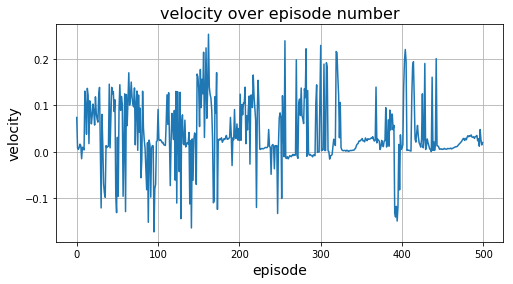

In [9]:
plt.figure(figsize=(8,4))
plt.plot(mean_vel)
plt.xlabel("episode", fontsize=14)
plt.ylabel("velocity", fontsize = 14)
plt.title("velocity over episode number", fontsize = 16)
plt.grid()

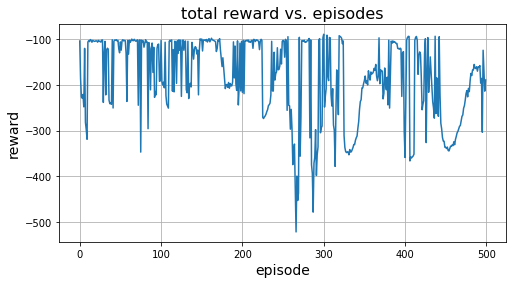

In [10]:
plt.figure(figsize=(8,4))
plt.plot(tot_ep_reward)
plt.xlabel("episode", fontsize=14)
plt.ylabel("reward", fontsize = 14)
plt.title("total reward vs. episodes", fontsize = 16)
plt.grid()

### Watch the agent play an episode

This is the fun part!
Now we get to see how good our agent really is by watching it play an episode.

In [14]:
ep_reward = []
ep_obs = []
env = gym.make('BipedalWalker-v2')
# env._max_episode_steps = 3000
# env = gym.wrappers.Monitor(env, "recording/LunarLander")
with tf.Session() as sess:
    saver.restore(sess, "models/BipedalWalker/model.ckpt") # load model
    obs = env.reset() # Reset env and save observation
    t = 0
    while True:
        env.render() # Render game
        # Use our model to create a probability distribution of actions based on observation
        action = np.squeeze(sess.run(sample_action, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
        # clip action values to fit into the allowed box
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
        obs, reward, done, info = env.step(action)
        ep_reward.append(reward)
        ep_obs.append(obs)
        t = t+1
        if done:
            ep_obs = np.vstack(ep_obs)
            print("Game ended after {} steps".format(t+1))
            print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
            print("Sum of x velocity in this episode {}".format(np.mean(ep_obs[:,2])))
            break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from models/BipedalWalker/model.ckpt
Game ended after 1601 steps
Total reward earned in this episode: -73.31
Sum of x velocity in this episode 0.018663935171400952


In [12]:
num_ep = 100
ep_reward = []
batch_reward = []
env = gym.make('BipedalWalker-v2')
# env._max_episode_steps = 1000
with tf.Session() as sess:
    saver.restore(sess, "models/BipedalWalker/model.ckpt") # load model
    for ep in range(num_ep):
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            # Use our model to create a probability distribution of actions based on observation
            action = np.squeeze(sess.run(sample_action, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
            # clip action values to fit into the allowed box
            action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward)
            t = t+1
            if done:
                print("-------------------------------------------")
                print("Game ended after {} steps".format(t+1))
                print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
                batch_reward.append(sum(ep_reward))
                ep_reward = []
                break
print("===================================================")
print("Average reward in batch is {:0.2f}".format(np.mean(batch_reward)))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from models/BipedalWalker/model.ckpt
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -73.07
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -68.69
-------------------------------------------
Game ended after 1475 steps
Total reward earned in this episode: -156.08
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -71.52
-------------------------------------------
Game ended after 1531 steps
Total reward earned in this episode: -169.94
-------------------------------------------
Game ended after 1162 steps
Total reward earned in this episode: -149.89
-----------------------------

-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -72.19
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -74.11
-------------------------------------------
Game ended after 1076 steps
Total reward earned in this episode: -150.87
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -65.44
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -78.80
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -78.90
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -76.33
-------------------------------------------
Game ended after 1601 steps
Total reward earned in this episode: -77.58
-------------------------------------------
Game ended after 1601 steps